# Import libraries

In [90]:
import pandas as pd #data frames (for storing data)
import numpy as np #scientific computing
import itertools

#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks
import scikitplot as skplt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split #Data split function
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from collections import Counter

import plotly.express as px

## 1. Load data 

In [91]:
data = pd.read_csv('marketing_data.csv')
data.dropna()
data.head(10).style #add .style to show all columns (otherwise some columns will be hidden with "...")

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP
5,7348,1958,PhD,Single,"$71,691.00",0,0,3/17/14,0,336,130,411,240,32,43,1,4,7,5,2,0,0,0,0,0,1,0,SP
6,4073,1954,2n Cycle,Married,"$63,564.00",0,0,1/29/14,0,769,80,252,15,34,65,1,10,10,7,6,1,0,0,0,0,1,0,GER
7,1991,1967,Graduation,Together,"$44,931.00",0,1,1/18/14,0,78,0,11,0,0,7,1,2,1,3,5,0,0,0,0,0,0,0,SP
8,4047,1954,PhD,Married,"$65,324.00",0,1,1/11/14,0,384,0,102,21,32,5,3,6,2,9,4,0,0,0,0,0,0,0,US
9,9477,1954,PhD,Married,"$65,324.00",0,1,1/11/14,0,384,0,102,21,32,5,3,6,2,9,4,0,0,0,0,0,0,0,IND


In [92]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

The dataset has 2240 rows (entries/instances/observations) and 28 columns (feature variables) of markjeting data. It provides insights about:
- Customer profiles 
- Products purchses 
- Marketing campaign success

### Input variables

1.	ID=Customer's unique identifier
2.	Year_Birth=Customer's birth year
3.	Education=Customer's education level
4.	Marital_Status=Customer's marital status
5.	Income=Customer's yearly household income
6.	Kidhome=Number of children in customer's household
7.	Teenhome=Number of teenagers in customer's household
8.	Dt_Customer=Date of customer's enrollment with the company
9.	Recency=Number of days since customer's last purchase
10.	MntWines=Amount spent on wine in the last 2 years
11.	MntFruits=Amount spent on fruits in the last 2 years
12.	MntMeatProducts=Amount spent on meat in the last 2 years
13.	MntFishProducts=Amount spent on fish in the last 2 years
14.	MntSweetProducts=Amount spent on sweets in the last 2 years
15.	MntGoldProds=Amount spent on gold in the last 2 years
16.	NumDealsPurchases=Number of purchases made with a discount
17.	NumWebPurchases=Number of purchases made through the company's web site
18.	NumCatalogPurchases=Number of purchases made using a catalogue
19.	NumStorePurchases=Number of purchases made directly in stores
20.	NumWebVisitsMonth=Number of visits to company's web site in the last month
21.	AcceptedCmp3=1 if customer accepted the offer in the 3rd campaign, 0 otherwise
22.	AcceptedCmp4=1 if customer accepted the offer in the 4th campaign, 0 otherwise
23.	AcceptedCmp5=1 if customer accepted the offer in the 5th campaign, 0 otherwise
24.	AcceptedCmp1=1 if customer accepted the offer in the 1st campaign, 0 otherwise
25.	AcceptedCmp2=1 if customer accepted the offer in the 2nd campaign, 0 otherwise
26.	Response=1 if customer accepted the offer in the last campaign, 0 otherwise
27.	Complain=1 if customer complained in the last 2 years, 0 otherwise
28.	Country=Customer's location

### Predict variables (desired target)

y — the customer accepted the odder in the last campagin? (binary: “1”, means “Yes”, “0” means “No”)

## 2. Exploratory Data Analysis 

Are there any null values or outliers? How will you wrangle/handle them?
Are there any variables that warrant transformations?
Are there any useful variables that you can engineer with the given data?
Do you notice any patterns or anomalies in the data? Can you plot them?
I'll do my best to answer above questions. This first section is separated into 3 parts:
1. Null values : In this part, I'll try to find all the missing values and impute them.
2. Outliers : In this part, I'll plot all the distribution of numerical data in order to detect some outliers and try to make sense of them.
3. Calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

### 2.1 Check NULL (missing) values and abnormal values

In [93]:
pd.DataFrame(data.isnull().sum(), columns=['#Null values']).T

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
#Null values,0,0,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We observe 
- the column " Income" show some missing values (all variables show 1100 entries)
- The column name ' Income ' has extra space so we need to strip it

#### Income

In [94]:
# Strip extra space in the column name 
data = data.rename(columns=lambda x: x.strip())

In [95]:
# Remove the '$' sign from the Income and converting the dtype from 'object' to 'float'
def income_convert(x):
    try: 
        return float(x.split('$')[1].split('.')[0].replace(',',''))
    except AttributeError: # as there are some missing values 
        return np.NaN
    
data['Income'] =  data['Income'].apply(income_convert) 
data['Income']= data['Income'].fillna(data['Income'].median())

#### Marital Status and Education 

In [96]:
print(data['Marital_Status'].unique())
print(data['Education'].unique())

['Divorced' 'Single' 'Married' 'Together' 'Widow' 'YOLO' 'Alone' 'Absurd']
['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']


In [97]:
# In Marital status, the attribute "YOLO", "ABSURD" should be considered the same as "single"
data.Marital_Status.replace({'Alone':'Single','YOLO':'Single','Absurd':'Single'}, inplace = True)
# In education level, the value '2n Cycle' is technically euivalent to 'Master'
data.Education.replace({'2n Cycle':'Master'}, inplace = True)
print(data.Marital_Status.unique())
print(data.Education.unique())

['Divorced' 'Single' 'Married' 'Together' 'Widow']
['Graduation' 'PhD' 'Master' 'Basic']


#### Transform Year_Birth to Age and Dt_Customer to Enrollment duration

In [98]:
# Transform the year_birth into age 
from datetime import date
Age = date.today().year-data['Year_Birth']
data.insert(1, 'Age', Age,)
dtime = pd.to_datetime(data['Dt_Customer'])
# Transform the Dt_customer into enrollment duration
Enroll_duration = date.today().year - dtime.dt.year
data.insert(7, 'Enrollment_duration', Enroll_duration)

### 2.2 Check outliers  

#### Age

In [99]:
#create a box plot

fig_age = px.box(data, y= 'Age')

fig_age.show()

We have notice that there are 3 people at age 122, 123, and 129, which is quite impossible. Therefore, we can conclude that there are some mistakes in this data collection. In this situation, we decide to either remove that observations for those people or replace them by the median of "age" column. 


In [100]:
data.loc[data['Age'] > 85, 'Age'] = int(data['Age'].median())
data['Age'].unique()

array([52, 61, 64, 55, 33, 68, 75, 43, 63, 41, 53, 45, 62, 56, 46, 57, 66,
       47, 51, 36, 50, 48, 32, 35, 38, 54, 67, 39, 49, 44, 70, 60, 58, 40,
       59, 65, 42, 77, 73, 74, 69, 76, 37, 30, 78, 71, 34, 72, 28, 29, 31,
       26, 27, 79, 81, 82])

In [101]:
#create a box plot

fig_income = px.box(data, y= 'Income')

fig_income.show()

According to the box plot, the income has three outliers, so we can replace them with the median of the Income 

In [102]:
data.loc[data['Income'] > 153923, 'Income'] = int(data['Income'].median())
data['Income'].max()

113734.0

#### 2.3 Some descriptive statistics

In [103]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Age,2240.0,53.096875,11.694144,26.0,45.00,52.0,63.00,82.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2240.0,51630.034375,20564.846870,1730.0,35538.75,51381.5,68098.25,113734.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Enrollment_duration,2240.0,8.971875,0.684554,8.0,9.00,9.0,9.00,10.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0


## 3. Data Visualisation

### 3.1 Response vs non-response situation 

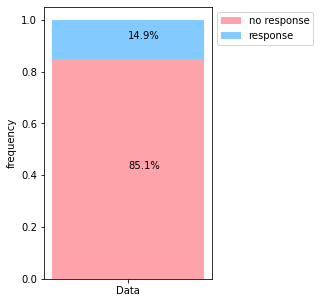

In [104]:
# plot reponse vs. non-response 
c = ['#FEA3AA', '#82CAFF']
keys, counts = np.unique(data.Response, return_counts=True)
counts_norm = counts/counts.sum()
fig = plt.figure(figsize=(3, 5)) #specify figure size
ax1 = plt.bar(['Data'], [counts_norm[0]], label='no response', color=c[0])
ax1 = plt.bar(['Data'], [counts_norm[1]], bottom=counts_norm[0], label='response', color=c[1])
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Data'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Data'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.show()

We observe that the non-response cases account for about 85.1% of all observations. This imbalanced distribution of the response variable (response) occurs in many real-life Data Science problems and requires careful consideration when designing a classification model.

### 3.2 Responses by some important features 

#### Reponse by education level

Text(0.5, 0, 'Education')

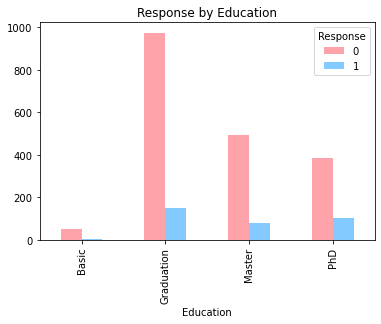

In [105]:
%matplotlib inline
ax = pd.crosstab(data.Education, data.Response).plot(kind='bar', color=c)
plt.title('Response by Education')
plt.xlabel('Education')

#### Reponse by Maritial_Status 

Text(0.5, 0, 'Maritual Status')

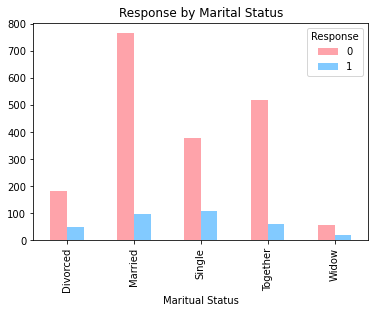

In [106]:
%matplotlib inline
ax = pd.crosstab(data.Marital_Status, data.Response).plot(kind='bar', color=c)
plt.title('Response by Marital Status')
plt.xlabel('Maritual Status')

#### Response by the Enrollment_duration

Text(0.5, 0, 'Years of enrollment')

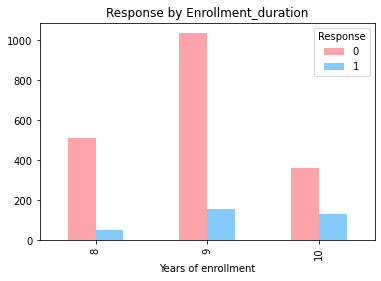

In [107]:
%matplotlib inline
ax = pd.crosstab(data.Enrollment_duration,data.Response).plot(kind='bar', color=c)
plt.title('Response by Enrollment_duration')
plt.xlabel('Years of enrollment')
#plt.savefig('purchase_fre_job')
#ax.legend(title = 'Response', bbox_to_anchor=(1, 1.02),loc='upper left')

#### Response by Teenhome

Text(0.5, 0, 'Teenhome')

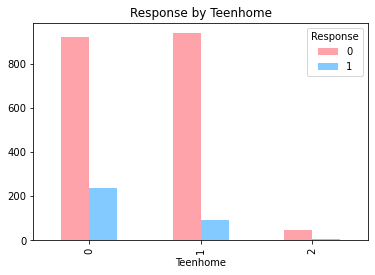

In [108]:
%matplotlib inline
ax = pd.crosstab(data.Teenhome,data.Response).plot(kind='bar', color=c)
plt.title('Response by Teenhome')
plt.xlabel('Teenhome')

#### Response by Kidhome 

Text(0.5, 0, 'Kidhome')

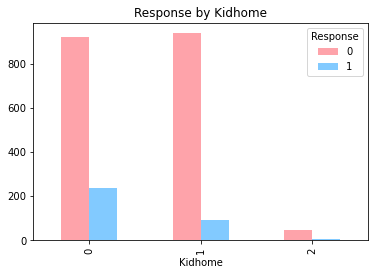

In [109]:
%matplotlib inline
ax = pd.crosstab(data.Teenhome,data.Response).plot(kind='bar', color=c)
plt.title('Response by Kidhome')
plt.xlabel('Kidhome')

#### Resopnse by country

Text(0.5, 0, 'Country')

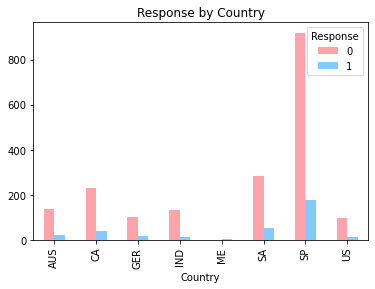

In [110]:
%matplotlib inline
ax = pd.crosstab(data.Country,data.Response).plot(kind='bar', color=c)
plt.title('Response by Country')
plt.xlabel('Country')

#### Response by age

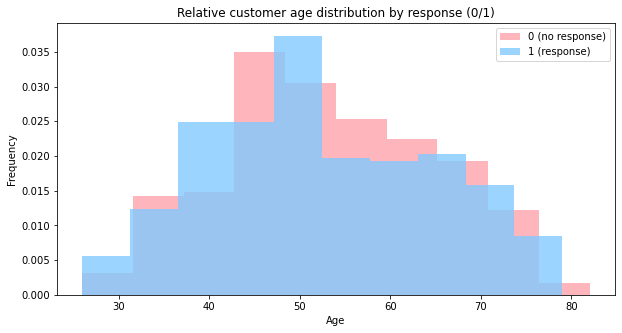

In [111]:
ax = data['Age'].loc[data['Response'] == 0].plot.hist(bins=10, density = True, alpha=0.8, label='0 (no response)', figsize = (10,5), color = c[0])
ax = data['Age'].loc[data['Response'] == 1].plot.hist(bins=10, density = True, alpha=0.8, label='1 (response)', figsize = (10,5), color = c[1])
ax.set_xlabel('Age')
ax.set_title('Relative customer age distribution by response (0/1)')
ax.legend();

#### Response by Income 

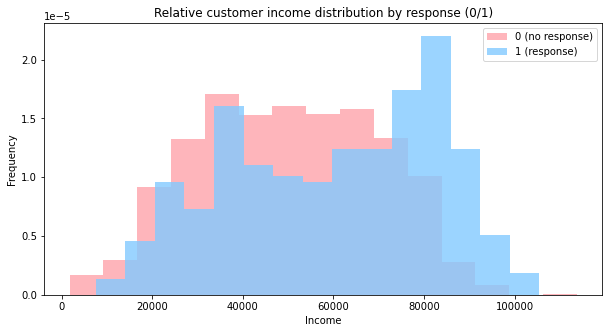

In [112]:
ax = data['Income'].loc[data['Response'] == 0].plot.hist(bins=15, density = True, alpha=0.8, label='0 (no response)', figsize = (10,5), color = c[0])
ax = data['Income'].loc[data['Response'] == 1].plot.hist(bins=15, density = True, alpha=0.8, label='1 (response)', figsize = (10,5), color = c[1])
ax.set_xlabel('Income')
ax.set_title('Relative customer income distribution by response (0/1)')
ax.legend();

#### Accepted the last Campaign

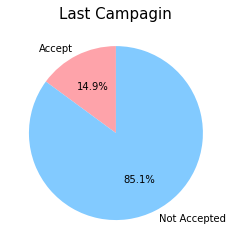

In [113]:
label = 'Accept','Not Accepted'
plt.pie([len(data['Response'][data['Response']==1]),len(data['Response'][data['Response']==0])],labels=label,autopct='%1.1f%%', startangle=90, colors = c)
plt.title('Last Campagin', size = 15);

## 4. Data cleaning & Pre-processing 

#### 4.1 Remove variables that have no explanatory power or have beend stranformed 

In [114]:
data = data.drop(columns=['ID', 'Year_Birth', 'Dt_Customer'])

In [115]:
data.head()

,Age,Education,Marital_Status,Income,Kidhome,Enrollment_duration,Teenhome,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,52,Graduation,Divorced,84835.0,0,8,0,0,189,104,...,6,1,0,0,0,0,0,1,0,SP
1,61,Graduation,Single,57091.0,0,8,0,0,464,5,...,7,5,0,0,0,0,1,1,0,CA
2,64,Graduation,Married,67267.0,0,8,1,0,134,11,...,5,2,0,0,0,0,0,0,0,US
3,55,Graduation,Together,32474.0,1,8,1,0,10,0,...,2,7,0,0,0,0,0,0,0,AUS
4,33,Graduation,Single,21474.0,1,8,0,0,6,16,...,2,7,1,0,0,0,0,1,0,SP


#### 4.2 Process the time series variables

dtime = pd.to_datetime(data['Dt_Customer'])
day, month, year = list(dtime.dt.day), list(dtime.dt.month), list(dtime.dt.year)
data=pd.concat([data.drop(columns=['Dt_Customer']),pd.DataFrame(day,columns=['day']),pd.DataFrame(month,columns=['month']),pd.DataFrame(year,columns=['year'])],axis=1)

#### 4.2 Encode categorical variables

In [116]:
data.head()

,Age,Education,Marital_Status,Income,Kidhome,Enrollment_duration,Teenhome,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,52,Graduation,Divorced,84835.0,0,8,0,0,189,104,...,6,1,0,0,0,0,0,1,0,SP
1,61,Graduation,Single,57091.0,0,8,0,0,464,5,...,7,5,0,0,0,0,1,1,0,CA
2,64,Graduation,Married,67267.0,0,8,1,0,134,11,...,5,2,0,0,0,0,0,0,0,US
3,55,Graduation,Together,32474.0,1,8,1,0,10,0,...,2,7,0,0,0,0,0,0,0,AUS
4,33,Graduation,Single,21474.0,1,8,0,0,6,16,...,2,7,1,0,0,0,0,1,0,SP


In [117]:
data = pd.get_dummies(data, columns=["Education", 'Marital_Status', 'Country'], drop_first = True) #we add a prefix for easier identification
data.head().style

,Age,Income,Kidhome,Enrollment_duration,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Country_CA,Country_GER,Country_IND,Country_ME,Country_SA,Country_SP,Country_US
0,52,84835.000000,0,8,0,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,61,57091.000000,0,8,0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
2,64,67267.000000,0,8,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
3,55,32474.000000,1,8,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,33,21474.000000,1,8,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0


In [118]:
data.shape

(2240, 38)

## 5. Data split 

To simulate this, we split our dataset into two subsets: training and testing. We use the training partition to build the model and the testing partition to evaluate the model performance.

We split the data 70:30 into a training (data_train) and a testing (data_test) partition. Furthermore, we split the dataset into a feature matrix X (all columns, except the target fraudulent column) and a label vector y (only the fraudulent column).

In [119]:
X, y = data.loc[:, data.columns != 'Response'], data['Response'] #define feature matrix X and labels y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345) #split data 70:30

We visualize the split to ensure that the distribution of fraudulent to non-fraudulent cases matches the distribution in the full dataset.

In [120]:
print('Train_x:',X_train.shape)
print('Train_y:',y_train.shape)
print('Test_x:',X_test.shape)
print('Test_y:',y_test.shape)

Train_x: (1568, 37)
Train_y: (1568,)
Test_x: (672, 37)
Test_y: (672,)


##  6. Rebalancing using SMOTE

In [121]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train) #ONLY APPLIED TO TRAINING!!!

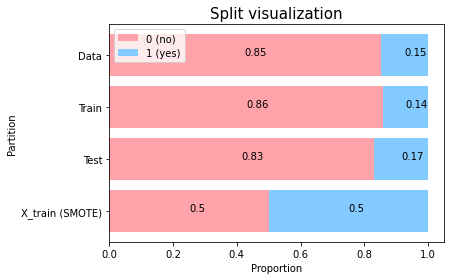

In [122]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color=c[0], label='0 (no)')
ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color=c[1], label='1 (yes)')
ax.set_title('Split visualization', size = 15)
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['X_train (SMOTE)', 'Test', 'Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## 7. Model Building 

###  Build imbalanced Logistic model

In [123]:
clf = LogisticRegression(solver='liblinear')
#clf = LogisticRegression(random_state=42,max_iter=10000)
#clf = LogisticRegression(random_state=42,C=0.8)
clf.fit(X_train, y_train) #define Logistic Regression classifier

LogisticRegression(solver='liblinear')

In [124]:
#Use classifier to predict labels
y_pred = clf.predict(X_test)

In [125]:
# Probabilities
y_pred_probs = clf.predict_proba(X_test)

# Cross-validation

In [146]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=10)
accuracy = []
f_score = []
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    #sm = SMOTE()
    #X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    model = LogisticRegression(solver='liblinear')  # Choose a model here
    model.fit(X_train, y_train )  
    y_pred = model.predict(X_test)
    #print(f'For fold {fold}:')
    accuracy.append(model.score(X_test, y_test))
    f_score.append(f1_score(y_test, y_pred))
print((np.array(accuracy).mean()*100).round(2))
print((np.array(f_score).mean()*100).round(2))

85.0
22.65


### Build a balanced Logistic Regression model

In [127]:
clf_b = LogisticRegression(solver='liblinear')
#clf = LogisticRegression(random_state=42,max_iter=10000)
#clf = LogisticRegression(random_state=42,C=0.8)
clf_b.fit(X_sm, y_sm) #define Logistic Regression classifier

LogisticRegression(solver='liblinear')

In [128]:
#Use classifier to predict labels
y_pred_b = clf_b.predict(X_test)

In [129]:
# Probabilities
y_pred_b_probs = clf_b.predict_proba(X_test)

In [130]:
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_b)*100).round(2))
print ("F_score is: ", (f1_score(y_test, y_pred_b)*100).round(2))

Accuracy is:  87.72
F_score is:  44.44


## Cross Validation 

In [145]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=10)
accuracy = []
f_score = []
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    model = LogisticRegression(solver='liblinear')  # Choose a model here
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(X_test)
    #print(f'For fold {fold}:')
    accuracy.append(model.score(X_test, y_test))
    f_score.append(f1_score(y_test, y_pred))
print((np.array(accuracy).mean()*100).round(2))
print((np.array(f_score).mean()*100).round(2))

83.66
51.35


## 7. Model Evaluation 

In this project, we will use the following evaluation metrics:
  - Confusion matrix
  - AUC (Area Under the Curve) and ROC curve
  - Gains chart
 

### 7.1 Confustion Matrix 

In [132]:
conf_mat = confusion_matrix(y_test, y_pred)
#raise NotImplementedError()

## sanity check
assert conf_mat.shape == (2,2)
print(conf_mat) #print the confusion matrix

[[381   1]
 [ 58   8]]


In [133]:
precision = conf_mat[-1,-1]/sum(conf_mat[:, 1])*100
print('The precision of the model is: ',precision)

assert isinstance(precision, float)

The precision of the model is:  88.88888888888889


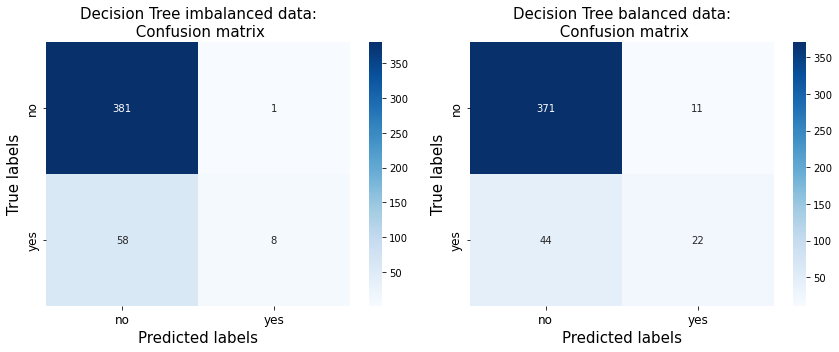

In [134]:
# Visualize the confusion matrix you computed
class_names = ['no', 'yes']

# Imbalanced data Confusion Matrix
plt.figure(figsize=(12, 5))
plt.subplot()

ax1= plt.subplot(1, 2, 1)
conf_mat_1 = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat_1, annot=True, fmt='g', ax=ax1, cmap="Blues")
ax1.set_xlabel('Predicted labels',fontsize=15)
ax1.set_ylabel('True labels',fontsize=15)
ax1.set_title('Decision Tree imbalanced data:\n Confusion matrix',fontsize=15)
ax1.xaxis.set_ticklabels(class_names,fontsize=12)
ax1.yaxis.set_ticklabels(class_names,fontsize=12)

ax2= plt.subplot(1,2,2)
conf_mat_2 = confusion_matrix(y_test, y_pred_b)
sns.heatmap(conf_mat_2, annot=True, fmt='g', ax=ax2, cmap="Blues")
ax2.set_xlabel('Predicted labels',fontsize=15)
ax2.set_ylabel('True labels',fontsize=15)
ax2.set_title('Decision Tree balanced data:\n Confusion matrix',fontsize=15)
ax2.xaxis.set_ticklabels(class_names,fontsize=12)
ax2.yaxis.set_ticklabels(class_names,fontsize=12)

plt.tight_layout()
plt.show()

## 7.2 Evaluation metrics - Precision, Recall, F-measure and support

In [135]:
# For balanced data 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_b))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       382
           1       0.67      0.33      0.44        66

    accuracy                           0.88       448
   macro avg       0.78      0.65      0.69       448
weighted avg       0.86      0.88      0.86       448



In [140]:
# For imbalanced data 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       382
           1       0.89      0.12      0.21        66

    accuracy                           0.87       448
   macro avg       0.88      0.56      0.57       448
weighted avg       0.87      0.87      0.82       448



### 7.3 AUC & ROC curve

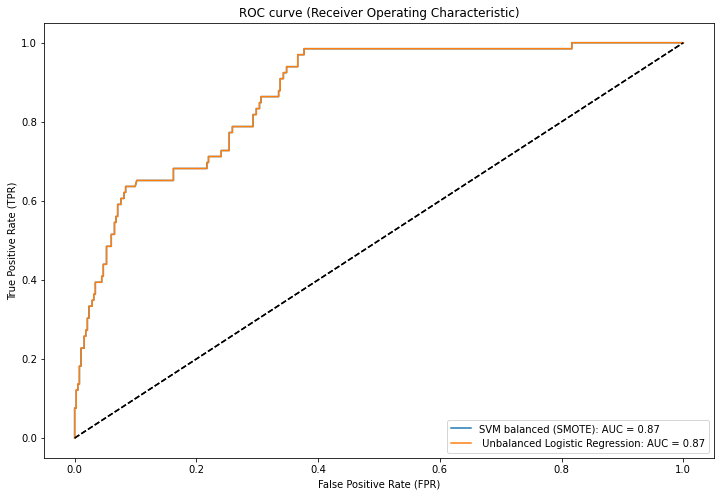

In [139]:
plt.figure(figsize=(12,8))

for test, pred, name in zip([y_test, y_test], [y_pred_b_probs[:,1], y_pred_b_probs[:,1]], ['SVM balanced (SMOTE)', ' Unbalanced Logistic Regression']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()